In [1]:
'''
A notebook which allows a pretrained detector to be applied to 
any audio file.
'''
%load_ext autoreload
%autoreload 2
%matplotlib inline

# General imports
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import yaml
import cPickle as pickle
from scipy.ndimage.interpolation import zoom

# Neural network imports
import nolearn
import lasagne

# Custom functions and classes
sys.path.append('..')
from lib import train_helpers

# Wav file loading and manipulation
import librosa
from librosa.feature import melspectrogram

Using gpu device 0: GeForce GTX 770 (CNMeM is disabled, cuDNN 5110)
/home/michael/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/michael/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/home/michael/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_

## Testing options

In [7]:
# You can provide here either:
#   A path to a single .wav file, 
# or
#   A path to a folder which contains one or more .wav files
#
# In this example code, we give a folder which contains a single .wav file.
# We could also give the complete path to this file - the result would be the same
# test_file_or_folder = '/home/michael/Dropbox/FairbrassFirmanetal_/models/example_test_data/'
# test_file_or_folder = '/media/michael/Engage/data/audio/alison_data/diversity_labelled_data/'
test_file_or_folder = '/media/michael/Engage/data/audio/alison_data/golden_set/wavs/'

# specify where the pretrained model is that we want to load
models_dir = '/home/michael/Dropbox/FairbrassFirmanetal_/data/models/biotic_trained_large/'

# Specify the names of the files we want to load in
# (Keep as they are to load in the model in the dropbox folder)
weights_path = os.path.join(models_dir, 'weights_99.pkl')
options_path = os.path.join(models_dir, 'network_params.yaml')

In [8]:
# Loading the options for network architecture, spectrogram type etc
options = yaml.load(open(options_path))

# Checking the weights exist
assert os.path.exists(weights_path), 'Error - cannot find the weights file at ' + weights_path

## Finding the .wav files to test on

In [9]:
if os.path.isdir(test_file_or_folder):
    
    # User provided a folder - we must get the list of wav files
    wav_dir = test_file_or_folder
    filenames = [xx for xx in os.listdir(wav_dir) if xx.endswith('.wav')]
    assert len(filenames), 'Error - no files found!'

elif os.path.isfile(test_file_or_folder):
    
    # User provided a file - we must deal with the filename appropriately
    wav_dir = os.path.dirname(test_file_or_folder)
    filenames = [os.path.basename(test_file_or_folder)]

else:
    raise Exception("No such file or folder: ", test_file_or_folder)
    
print "We will load %d file(s) from the folder:" % len(filenames)
print wav_dir
print 
print "Files are:"
for filename in filenames:
    print "  -", filename

We will load 40 file(s) from the folder:
/media/michael/Engage/data/audio/alison_data/golden_set/wavs/

Files are:
  - E29RR-013378_20150530_03000023.wav
  - CM167NP-3527_20150910_07300016.wav
  - HA53AA-13548_20130727_0954.wav
  - TW76ER-13534_20150625_1000009.wav
  - CR8-13548_20130918_1109.wav
  - IG62XL-13534_20150514_17300028.wav
  - CR05EF-13527_20130921_1236.wav
  - IG62XL-13534_20150512_21000014.wav
  - SW154LA-3527_20130705_0909.wav
  - DA5-011881_20150827_1830007.wav
  - DA5-011881_20150826_08000016.wav
  - HA86RB-13527_20130730_0541.wav
  - E29RR-013378_20150531_05300014.wav
  - TW76ER-13534_20150623_2000008.wav
  - BR4-013378_20150825_0200003.wav
  - W112NN-13548_20130709_1234.wav
  - BR20EG-13548_20150720_12000019.wav
  - SE3-13548_20130911_0655.wav
  - CR8-13548_20130921_0806.wav
  - TW76ER-13534_20150626_02300015.wav
  - W112NN-13548_20130709_0403.wav
  - SE23-13527_20130907_1651.wav
  - HA53AA-13548_20130730_0305.wav
  - BR67US-13534_20150801_12300024.wav
  - BR4-013378

## Setting up network

In [10]:
# Create the layers of the neural network, with the same options we used in training
net_options = {xx: options[xx] for xx in train_helpers.net_params}
network = train_helpers.create_net(**net_options)

# Create an object which will iterate over the test spectrograms appropriately
test_sampler = train_helpers.SpecSampler(
    4, options['HWW'], False, options['LEARN_LOG'], randomise=0, seed=10)

# Create a nolearn object to contain the network and push data through it
net = nolearn.lasagne.NeuralNet(
    layers=network['prob'], update=lasagne.updates.adam, batch_iterator_test=test_sampler)

# Initialise the network and load in the pretrained parameters
net.initialize()
net.load_params_from(weights_path)

/home/michael/anaconda/lib/python2.7/site-packages/nolearn/lasagne/base.py:430: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  for input_layer in input_layers]
/home/michael/anaconda/lib/python2.7/site-packages/nolearn/lasagne/base.py:431: UserWarning: The Param class is deprecated. Replace Param(default=N) by theano.In(value=N)
  inputs = X_inputs + [theano.Param(y_batch, name="y")]


## Generating spectrogram(s)

In [11]:
# We will store spectrograms in a dictionary, where keys are the filenames
specs = {}  

# Loop over each file we want to predict for
for filename in filenames:
    
    if filename in specs:
        continue

    # Read in the wav file
    wav, sample_rate = librosa.load(os.path.join(wav_dir, filename), 22050)

    # Compute the spectrogram
    spec = melspectrogram(wav, sr=sample_rate, n_fft=options['N_FFT'], 
                          hop_length=options['HOP_LENGTH'], n_mels=options['N_MELS'])

    # Do log conversion:
    spec = np.log(options['A'] + options['B'] * spec)
    spec -= np.median(spec, axis=1, keepdims=True)

    # Add to the dictionary
    specs[filename] = spec.astype(np.float32)

## Applying classifier

In [12]:
# Push this list through the network
# test_sampler, defined above, does the hard work here.
preds = {}

for filename in filenames:
    preds[filename] = net.predict_proba([specs[filename]])

## Loading the ground truth labels (for plotting)

In [68]:
# Loading in ground truth items - we assume these have the same names as the wav files
from data_helpers import load_annotations

to_plot = preds.keys()[0]

labels, _, _ = load_annotations(to_plot, wav_dir, wav_dir)

# Rescale the gt labels to be the same size as the spectrogram
ground_truth_labels = labels[options['CLASSNAME']]
factor = preds[to_plot].shape[0] / float(ground_truth_labels.shape[0])
ground_truth_labels = zoom(ground_truth_labels, factor)

## Plotting results

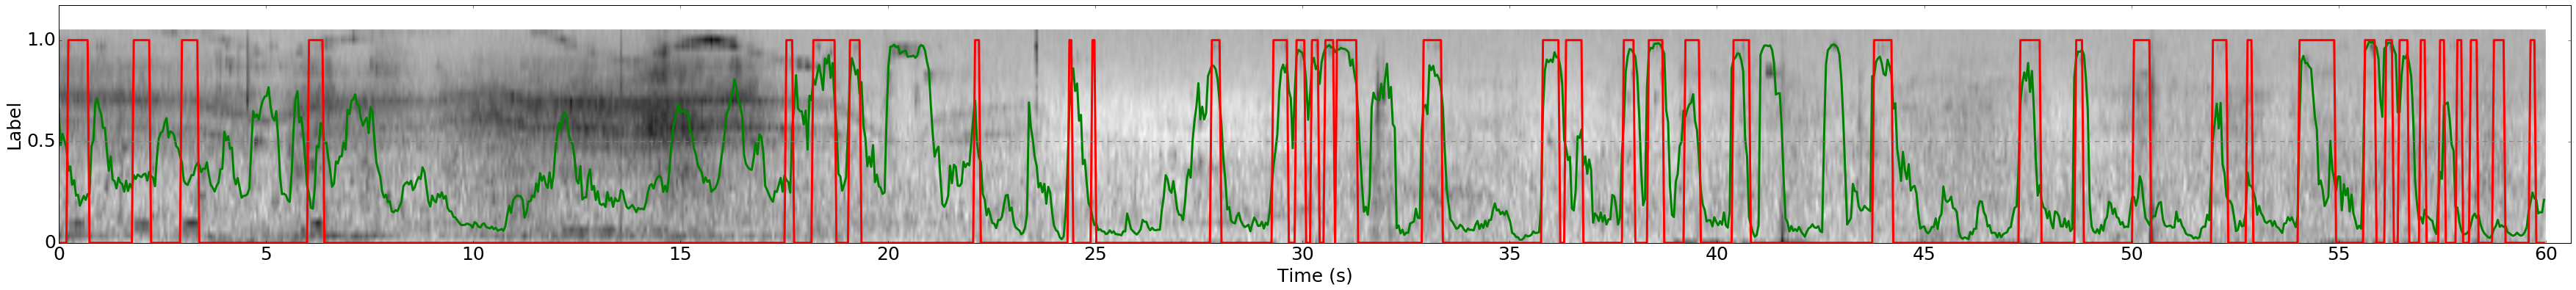

In [71]:
scale = 30  # a hack to make the graph look right
spec_bin_width_in_s = 60 / float(spec.shape[1])

fig = plt.figure(figsize=(50, 5))
ax = fig.add_axes((0.05,0.16,0.95,0.9))

# show spectrogram in the background
ax.imshow(specs[to_plot], cmap='gray_r', aspect='auto')

# plot the results on top
ax.plot(preds[to_plot][:, 1] * scale, 'g', label='Predicted', linewidth=3)
ax.plot(ground_truth_labels * scale, 'r', label='True', linewidth=3)
ax.plot(ground_truth_labels * 0 + scale/2, '--', color=[0.5, 0.5, 0.5], label='True')

# # sort out axes
ax.invert_yaxis()
plt.xlim(0, spec.shape[1] * 1.01)
plt.ylim(0, spec.shape[0] * 1.1)
plt.xticks(np.arange(0, 65, 5) / spec_bin_width_in_s, np.arange(0, 65, 5))
plt.yticks([0, scale/2, scale], [0, 0.5, 1.0])
plt.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Time (s)', fontsize=25)
plt.ylabel('Label', fontsize=25)

ax.grid('off')

## Saving results to disk

In [17]:
savedir = './tmp/preds/'
for fname, pred in preds.iteritems():
    with open(savedir + fname.replace('.wav', '_' + options['CLASSNAME'] + '.pkl'), 'w') as f:
        pickle.dump(pred, f, -1)

In [15]:
print specs.values()[0].shape
print preds.values()[0].shape

(32, 1292)
(1292, 2)


In [16]:
savedir = './tmp/specs/'
for fname, spec in specs.iteritems():
    with open(savedir + fname.replace('.wav', '.pkl'), 'w') as f:
        pickle.dump(spec, f, -1)